<a href="https://colab.research.google.com/github/Yuvansh1/Marketing_Analytics/blob/master/ML_Projects/CTR_Prediction_using_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CTR is a metric that measures the number of clicks advertisers receive on their ads per number of impressions.Mobile ads are expected to generate 1.08 billion dollar this year, which would be a 122% jump from last year.**


***Goal :- Given a user and the page he (or she) is visiting. what is the probability that he (or she) will click on a given ad? The goal of this analysis is to benchmark the most accurate ML algorithms for CTR estimation.***


In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Sep 14 19:39 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# List available datasets.
!kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
therohk/ireland-historical-news                           The Irish Times - Waxy-Wany News                   47MB  2019-08-24 15:36:54            902  
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                      2MB  2019-08-12 16:24:45          10788  
lakshyaag/india-trade-data                                India - Trade Data                                  1MB  2019-08-16 16:13:58           6235  
bradklassen/pga-tour-20102018-data                        PGA Tour Golf Data                                 94MB  2019-08-30 00:09:59           5301  
r3w0p4/bournemouth-venues                                 Venues in Bournemouth         

In [12]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c avazu-ctr-prediction

 99% 1.03G/1.04G [00:13<00:00, 73.4MB/s]
100% 1.04G/1.04G [00:13<00:00, 83.7MB/s]
 90% 106M/118M [00:02<00:00, 22.7MB/s] 
100% 118M/118M [00:02<00:00, 43.1MB/s]
 60% 20.0M/33.2M [00:00<00:00, 23.4MB/s]
100% 33.2M/33.2M [00:00<00:00, 67.3MB/s]


**EDA & Feature Engineering** :- 
The training set contains over 40 millions of records, to be able to process locally, we will randomly sample 1 million of them.

In [0]:
import numpy as n
import random
import pandas as pd
import gzip
n = 40428967  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
with gzip.open('train.gz') as f:
    train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, skiprows = skip_values)#dtype=types_train, )

In [24]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10034295299322669964,0,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,03a08c3f,7801e8d9,0f2161f8,30f17f5f,2df31c38,684581ce,4,3,21310,320,50,2449,0,163,100106,91
1,10037810025728838562,0,2014-10-21,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,0c8250d7,88fe1d5d,1,0,19771,320,50,2227,0,687,-1,48
2,1004326673744329635,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,592dcc7c,d787e91b,1,0,20362,320,50,2333,0,39,-1,157
3,10052561582444813739,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,5ba6ef40,d787e91b,1,0,15708,320,50,1722,0,35,-1,79
4,10053027485503883989,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,afa320bb,8a4875bd,1,0,15705,320,50,1722,0,35,100084,79


**Features :-** 
We can group all the features in the data into the following categories:

1.   Target feature : click
2.   site features : site_id, site_domain, site_category
3.   app feature: app_id, app_domain, app_category
4.   device feature: device_id, device_ip, device_model, device_type,  device_conn_type*
5.   anonymized categorical features: C14-C21






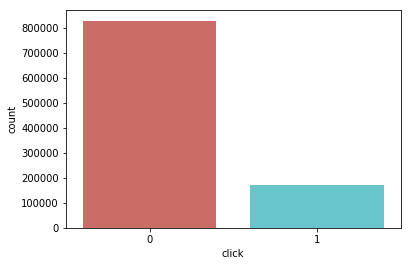

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='click',data=train, palette='hls')
plt.show();

In [26]:
train['click'].value_counts()/len(train)

0    0.829554
1    0.170446
Name: click, dtype: float64

**The overall click through rate is approx. 17%, and approx. 83% is not clicked.**

In [27]:
train.hour.describe()

count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    11113
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

**The data covers 10 days of click streams data from 2014–10–21 to 2014–10–30, that is 240 hours.**

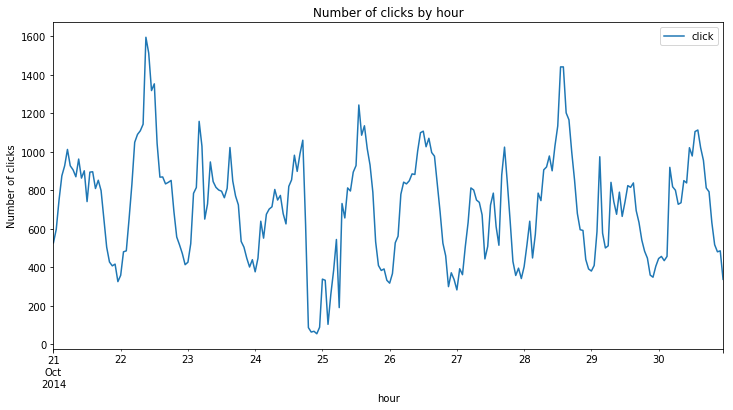

In [28]:
train.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

The hourly clicks pattern looks pretty similar every day. However, there were a couple of peak hours, one is sometime in the mid of the day on Oct 22, and another is sometime in the mid of the day on Oct 28. And one very low click hour is close to mid-night on Oct 24.

> **Feature engineering for date time features Hour** :- 


> Extract hour from date time feature.



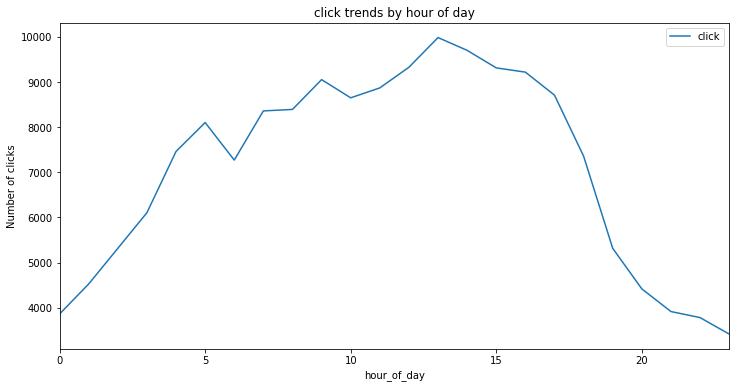

In [29]:
train['hour_of_day'] = train.hour.apply(lambda x: x.hour)
train.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

In general, the highest number of clicks is at hour 13 and 14 **(1pm and 2pm)**, and the lowest number of clicks is at hour 0 **(mid-night)**. It seems a useful feature for roughly estimation.

> Let’s take impressions into consideration.

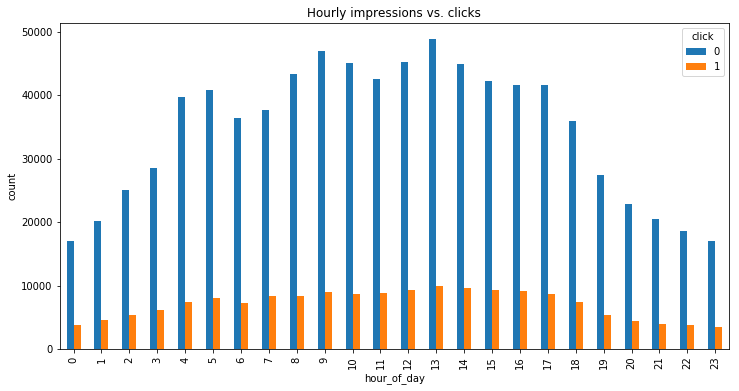

In [30]:
train.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');

## **Hourly CTR**

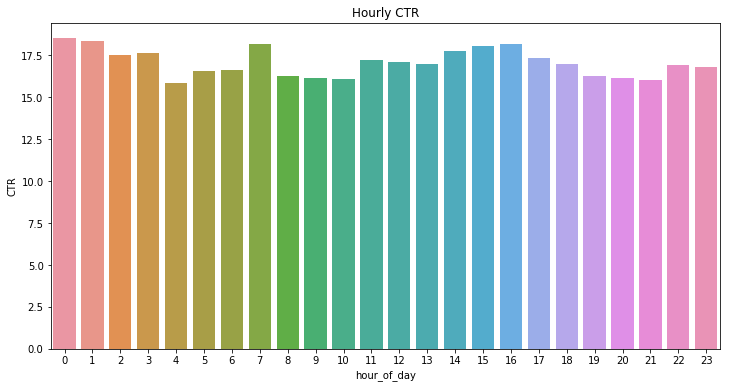

In [31]:
import seaborn as sns
df_click = train[train['click'] == 1]
df_hour = train[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_of_day', data=df_hour)
plt.title('Hourly CTR');

**One of the interesting observations here is that the highest CTR happened in the hour of mid-night, 1, 7 and 15. If you remember, around mid-night has the least number of impressions and clicks.**

## **Day of week**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """Entry point for launching an IPython kernel.


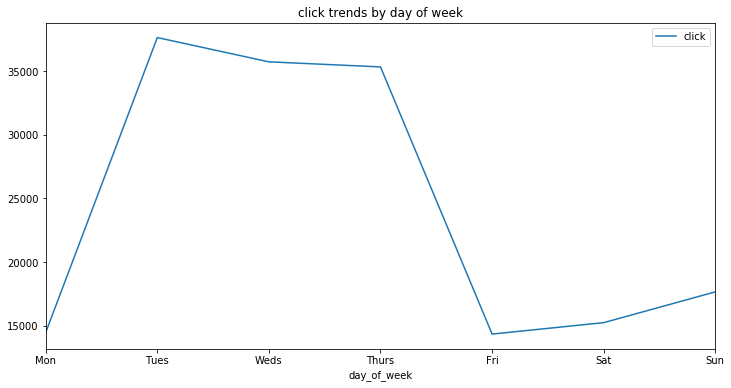

In [34]:
train['day_of_week'] = train['hour'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

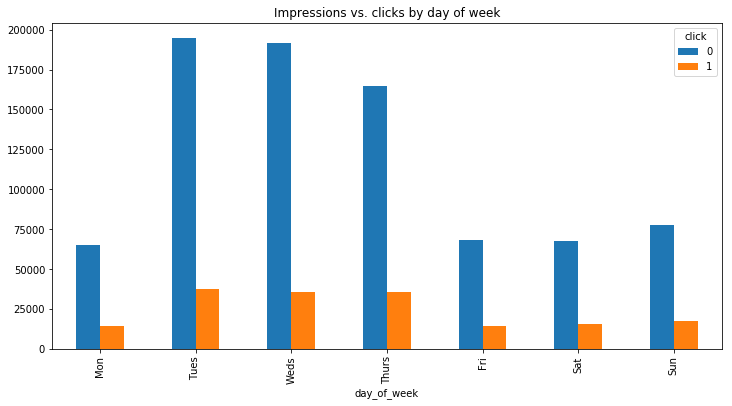

In [37]:
train.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

**Tuesdays have the most number of impressions and clicks, then Wednesdays, followed by Thursdays. Mondays and Fridays have the least number of impressions and clicks.**

## **Day of week CTR**

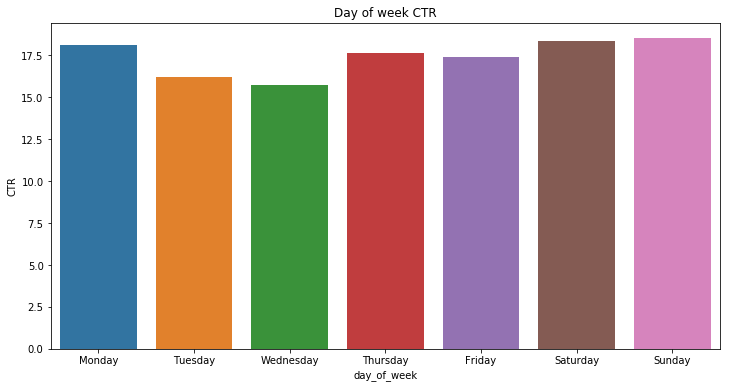

In [38]:
df_click = train[train['click'] == 1]
df_dayofweek = train[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

**While Tuesdays and Wednesdays have the highest number of impressions and clicks, their CTR are among the lowest. Saturdays and Sundays enjoy the highest CTR. Apparently, people have more time to click over the weekend.**

**C1 feature**


C1 is one of the anonymized categorical features. Although we don’t know its meaning, we still want to take a look its distribution.

In [39]:
print(train.C1.value_counts()/len(train))

1005    0.918736
1002    0.054985
1010    0.022219
1012    0.002852
1007    0.000849
1001    0.000205
1008    0.000154
Name: C1, dtype: float64


**C1 value = 1005 has the most data, almost 92% of all the data we are using. Let’s see whether we can find value of C1 indicates something about CTR.**

In [41]:
import numpy as np
C1_values = train.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=train.loc[np.where((train.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

for C1 value: 1001,  click through rate: 0.03414634146341464
for C1 value: 1002,  click through rate: 0.21262162407929436
for C1 value: 1005,  click through rate: 0.16987796276623535
for C1 value: 1007,  click through rate: 0.020023557126030624
for C1 value: 1008,  click through rate: 0.11688311688311688
for C1 value: 1010,  click through rate: 0.09626895899905487
for C1 value: 1012,  click through rate: 0.17566619915848528


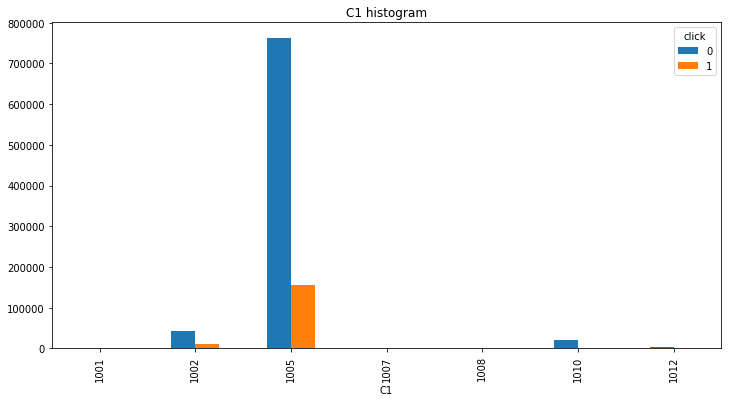

In [42]:
train.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram');

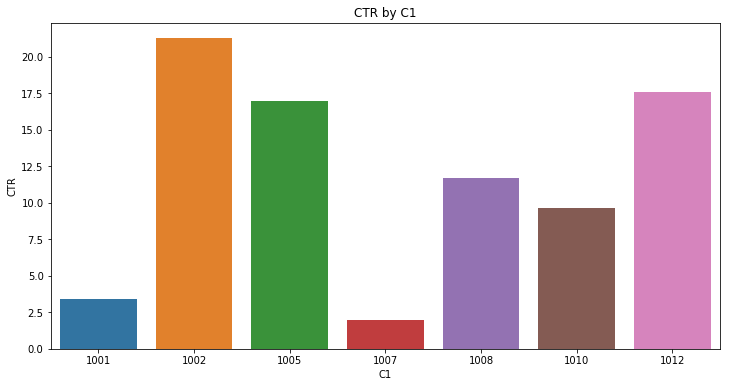

In [43]:
df_c1 = train[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1');

The important C1 values and CTR pairs are:

> C1=1005: 92% of the data and 0.17 CTR

> C1=1002: 5.5% of the data and 0.21 CTR

> C1=1010: 2.2% of the data and 0.095 CTR

> C1 = 1002 has a much higher than average CTR, and C1=1010 has a much lower than average CTR, it seems these two C1 values are important for predicting CTR.

## **Banner position**

I have heard that there are many factors that affect the performance of your banner ads, but the most influential one is the banner position. Let’s see whether it is true.

In [45]:
print(train.banner_pos.value_counts()/len(train))

0    0.719291
1    0.278912
7    0.001081
2    0.000333
4    0.000177
5    0.000154
3    0.000052
Name: banner_pos, dtype: float64


In [46]:
banner_pos = train.banner_pos.unique()
banner_pos.sort()
ctr_avg_list=[]
for i in banner_pos:
    ctr_avg=train.loc[np.where((train.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for banner position: {},  click through rate: {}".format(i,ctr_avg))

for banner position: 0,  click through rate: 0.16473443988594325
for banner position: 1,  click through rate: 0.18467473611748508
for banner position: 2,  click through rate: 0.1021021021021021
for banner position: 3,  click through rate: 0.19230769230769232
for banner position: 4,  click through rate: 0.20903954802259886
for banner position: 5,  click through rate: 0.11688311688311688
for banner position: 7,  click through rate: 0.3209990749306198


The important banner positions are:

> position 0: 72% of the data and 0.16 CTR

> position 1: 28% of the data and 0.18 CTR

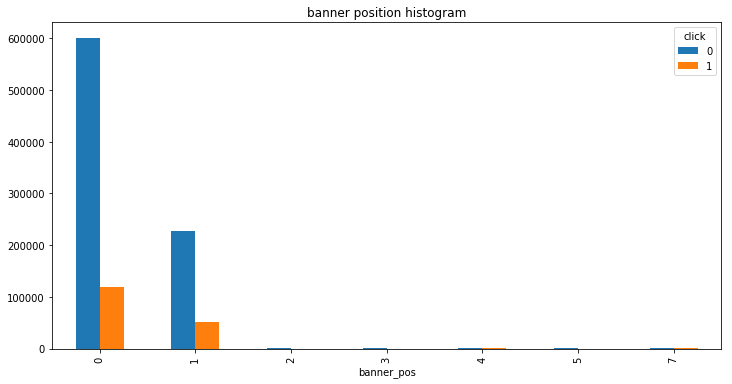

In [47]:
train.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram');

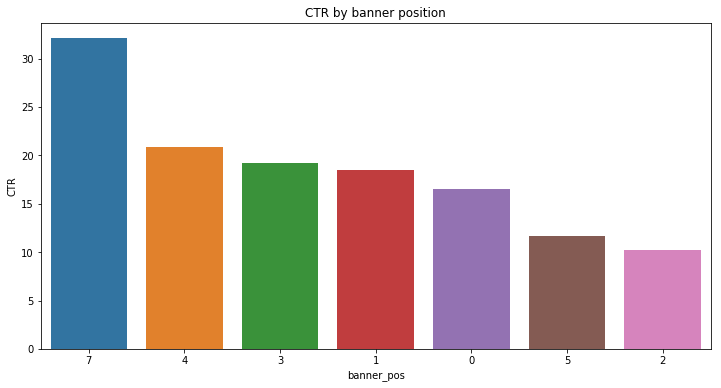

In [48]:
df_banner = train[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('CTR by banner position');

**Although banner position 0 has the highest number of impressions and clicks, banner position 7 enjoys the highest CTR. Increasing the number of ads placed on banner position 7 seems to be a good idea.**

## **Device type**

In [49]:
print('The impressions by device types')
print((train.device_type.value_counts()/len(train)))

The impressions by device types
1    0.922796
0    0.054985
4    0.019036
5    0.003183
Name: device_type, dtype: float64


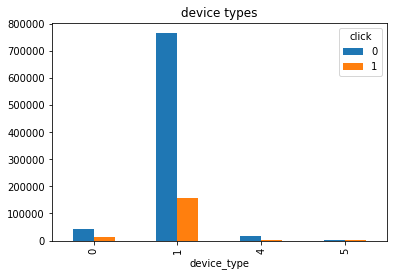

In [50]:
train[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar', title='device types');

**Device type 1 gets the most impressions and clicks, and the other device types only get the minimum impressions and clicks. We may want to look in more details about device type 1.**

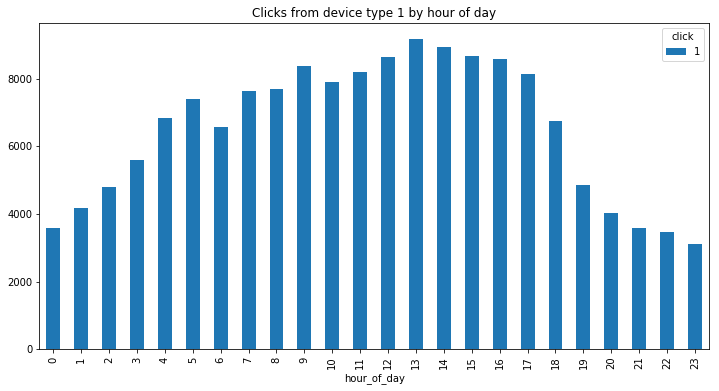

In [51]:
df_click[df_click['device_type']==1].groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Clicks from device type 1 by hour of day", figsize=(12,6));

**As expected, most clicks happened during the business hours from device type 1.**

In [52]:
device_type_click = df_click.groupby('device_type').agg({'click':'sum'}).reset_index()
device_type_impression = train.groupby('device_type').agg({'click':'count'}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left = device_type_click , right = device_type_impression, how = 'inner', on = 'device_type')
merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type['impressions']*100
merged_device_type

,device_type,click,impressions,CTR
0,0,11691,54985,21.262162
1,1,156616,922796,16.971898
2,4,1853,19036,9.734188
3,5,286,3183,8.985234


**The highest CTR comes from device type 0.**

## **Building Models**

## **Xgboost Model**

In [0]:
from operator import itemgetter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

def run_default_test(train, test, features, target, random_state=0):
    eta = 0.1
    max_depth = 5
    subsample = 0.8
    colsample_bytree = 0.8
    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "logloss",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state
    }
    num_boost_round = 260
    early_stopping_rounds = 20
    test_size = 0.2

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

In [78]:
features = ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_of_day',
       'site_id_int', 'site_domain_int', 'site_category_int', 'app_id_int',
       'app_domain_int', 'app_category_int', 'device_id_int', 'device_ip_int',
       'device_model_int', 'day_of_week_int']
run_default_test(train, y_target, features, 'click')

XGBoost params. ETA: 0.1, MAX_DEPTH: 5, SUBSAMPLE: 0.8, COLSAMPLE_BY_TREE: 0.8


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-logloss:0.648208	eval-logloss:0.64888
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.612805	eval-logloss:0.612823
[2]	train-logloss:0.58326	eval-logloss:0.582695
[3]	train-logloss:0.558224	eval-logloss:0.557856
[4]	train-logloss:0.537279	eval-logloss:0.536986
[5]	train-logloss:0.5194	eval-logloss:0.519509
[6]	train-logloss:0.504483	eval-logloss:0.504865
[7]	train-logloss:0.492699	eval-logloss:0.492418
[8]	train-logloss:0.481799	eval-logloss:0.481747
[9]	train-logloss:0.47291	eval-logloss:0.472866
[10]	train-logloss:0.465396	eval-logloss:0.465228
[11]	train-logloss:0.458408	eval-logloss:0.45869
[12]	train-logloss:0.453217	eval-logloss:0.453212
[13]	train-logloss:0.448263	eval-logloss:0.448366
[14]	train-logloss:0.444376	eval-logloss:0.444321
[15]	train-logloss:0.440775	eval-logloss:0.440566
[16]	train-logloss:0.437474	eval-logloss:0.437478
[17]	train-loglos

**It will train until eval-logloss hasn’t improved in 20 rounds. And the final output:**

> **[259]	train-logloss:0.400301	eval-logloss:0.402568**